# Modèle GARCH pour la prédiction de la volatilité

## Introduction

Le modèle GARCH (Generalized Autoregressive Conditional Heteroskedasticity) est une approche statistique utilisée pour modéliser et estimer la volatilité conditionnelle des rendements financiers.

Cette méthode s'avère particulièrement utile pour capturer les variations temporelles de la volatilité, ce qui est crucial dans l'évaluation des risques financiers et dans la modélisation des prix des actifs.

## Objectif

Le principal objectif du modèle GARCH est de modéliser la volatilité conditionnelle, c'est-à-dire la variation de la volatilité au fil du temps en fonction de l'information disponible jusqu'à ce moment. 

Il tient compte de l'hétéroscédasticité conditionnelle, une caractéristique observée dans les données financières où la volatilité change au fil du temps.

## Principe

Le modèle `GARCH` repose sur l'idée que la variance d'une série temporelle financière peut être modélisée comme une combinaison linéaire de ses valeurs passées et de ses erreurs passées. Ainsi, la volatilité conditionnelle à un instant donné dépend des rendements passés et des erreurs passées. Le modèle ajuste les paramètres pour minimiser l'erreur entre la volatilité estimée et la volatilité observée.

$$
\sigma_{t}^{2} = \omega + \sum_{i=1}^p \alpha_{i}\epsilon_{t-i}^{2} + \sum_{j=1}^q\beta{j}\sigma_{t-j}^{2}
$$

Où :
- $\sigma_{t}^{2}$ est la volatilité conditionnelle à l'instant t
- p (ordre autorégressif) : le nombre de rendements passés utilisés pour modéliser la volatilité conditionnelle.
- q (ordre de la moyenne mobile) : le nombre d'erreurs (résidus) passées utilisées pour le même but.
- $\epsilon_{t}$ est l'erreur à l'instant t
- $\omega, \alpha_{i}, \beta{j}$ sont les paramètres à estimer.

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import warnings
import seaborn as sns
from numpy import log, polyfit, sqrt, std, subtract
from pylab import rcParams 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 10,5

## Hurst Exponent function

Le `Exposant de Hurst` est une mesure statistique utilisée pour classer les séries temporelles et déduire le niveau de difficulté pour prédire et choisir un modèle approprié pour la série en cours. L'exposant de Hurst est utilisé comme mesure de la mémoire à long terme des séries temporelles. Il est lié aux autocorrélations des séries temporelles et à la vitesse à laquelle celles-ci diminuent à mesure que le décalage entre les paires de valeurs augmente.
$$
\tau(h)=\sqrt(Var(Ts(t+h)-Ts(t)))
$$
* Une valeur proche de `0.5` indique une série aléatoire.
* Une valeur proche de `0` indique une série de retour à la moyenne.
* Une valeur proche de `1` indique une série en tendance.

In [3]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values (valeurs de décalage)
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

## Correlogram Plot

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download S&P 500 Index Data

In [5]:
# Télécharger les données de S&P 500
sp_data = yf.download("^GSPC", start="2000-01-01", end="2023-01-01")
sp_data.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5787 entries, 2000-01-03 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5787 non-null   float64
 1   High       5787 non-null   float64
 2   Low        5787 non-null   float64
 3   Close      5787 non-null   float64
 4   Adj Close  5787 non-null   float64
 5   Volume     5787 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 316.5 KB


In [6]:
sp_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


### Observe volatility clustering

`Volatility clustering` fait référence à l'observation selon laquelle "les grands changements ont tendance à être suivis par de grands changements, de signe quel qu'il soit, et les petits changements ont tendance à être suivis par de petits changements."

* Volatility clustering est fréquemment observée dans les données des marchés financiers, et elle pose un défi pour la modélisation des séries temporelles.

Avec l'ensemble de données des prix quotidiens du S&P 500, nous calculons les rendements quotidiens sous forme de variations de pourcentage des prix, représentons les résultats et observons leur comportement au fil du temps.


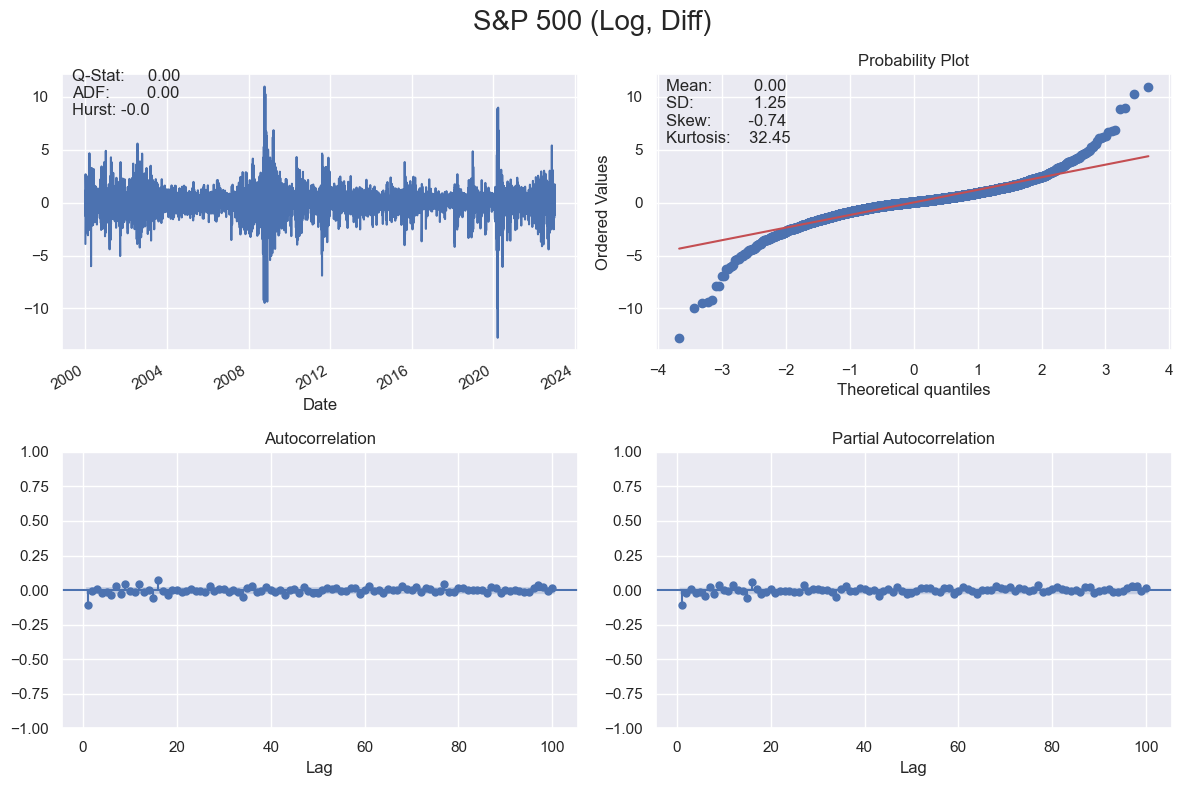

In [7]:
# Calculate daily returns as percentage price changes
sp_data['Return'] = 100 * (sp_data['Close'].pct_change())
sp_data['Log_Return'] = np.log(sp_data['Close']).diff().mul(100) # rescale to faciliate optimization
sp_data = sp_data.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(sp_data['Log_Return'], lags=100, title='S&P 500 (Log, Diff)')

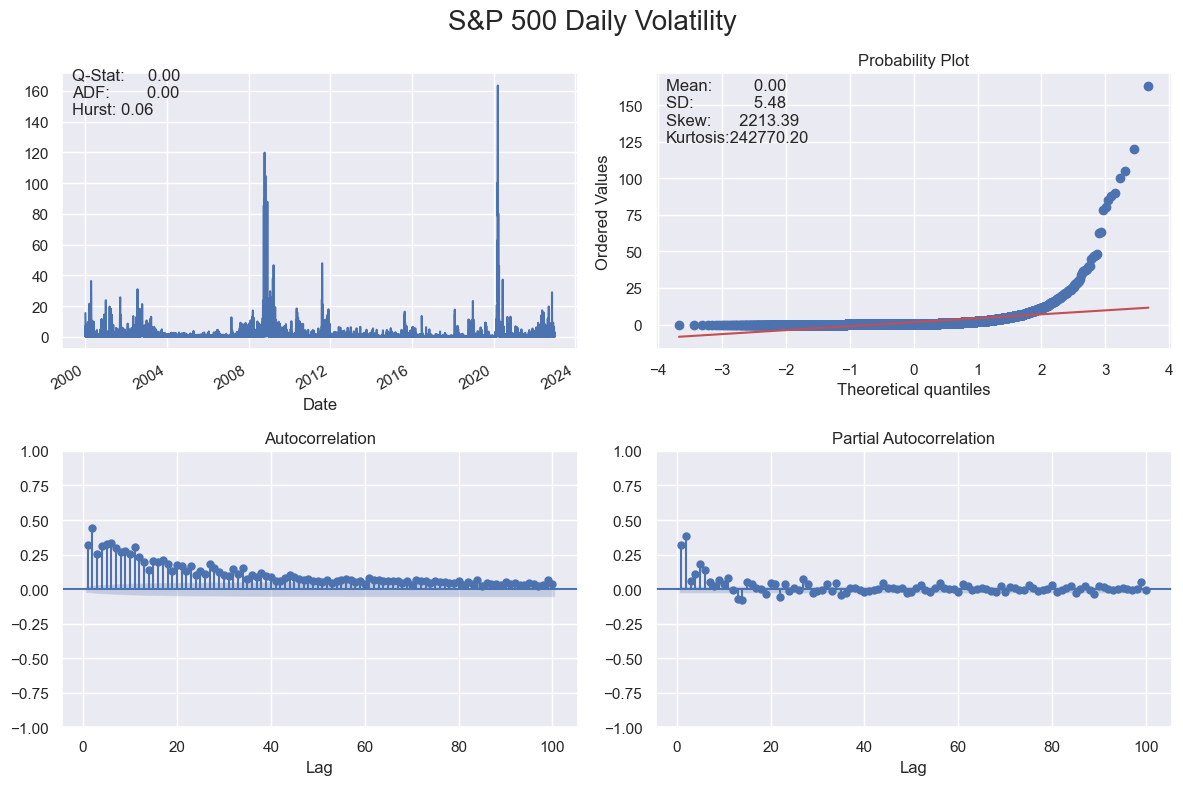

In [9]:
plot_correlogram(sp_data['Log_Return'].sub(sp_data['Log_Return'].mean()).pow(2), lags=100, title='S&P 500 Daily Volatility')

### Calculate volatility

Nous calculons et convertissons la volatilité des rendements des prix en Python.

Tout d'abord, nous calculons la volatilité quotidienne comme l'écart-type des rendements des prix. Ensuite, nous convertissons la volatilité quotidienne en volatilité mensuelle et annuelle.

In [10]:
# Calculate daily std of returns
std_daily = sp_data['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 1.25%

Monthly volatility: 5.73%

Annual volatility: 19.85%


### GARCH(1,1) parameter constraints

* All parameters are non-negative, so the variance cannot be negative.
$$\omega, \alpha, \beta \geq 0 $$
* Model estimations are "mean-reverting" to the long-run variance.
$$\alpha + \beta < 1 $$
* long-run variance:
$$\omega /(1-\alpha-\beta)$$

## GARCH(1,1) parameter dynamics
- Plus $\alpha$ est grand, plus l'impact immédiat du choc est important.
- Plus $\beta$ est grand, plus la durée de l'impact est longue.

Étant donnée l'équation du modèle $\operatorname{GARCH}(1,1)$ comme suit :
$$
\operatorname{GARCH}(1,1): \sigma_t^2=\omega+\alpha \epsilon_{t-1}^2+\beta \sigma_{t-1}^2
$$

De manière intuitive, la prévision de la variance GARCH peut être interprétée comme une moyenne pondérée de trois prévisions de variance différentes.

- Une est une variance constante qui correspond à la moyenne à long terme.
- La deuxième est la nouvelle information qui n'était pas disponible lorsque la prévision précédente a été faite.
- La troisième est la prévision qui a été faite lors de la période précédente.

Les poids attribués à ces trois prévisions déterminent à quelle vitesse la variance change avec de nouvelles informations et à quelle vitesse elle revient à sa moyenne à long terme.

### Simulate ARCH and GARCH series
Nous simulerons respectivement une série temporelle $\operatorname{ARCH}(1)$ et $\operatorname{GARCH}(1,1)$ en utilisant une fonction `simulate_GARCH( $n$, omega, alpha, beta $=0)$.
Rappelez-vous de la différence entre un modèle $\operatorname{ARCH}(1)$ et un modèle $\operatorname{GARCH}(1,1)$ : en plus d'une composante autorégressive de $\alpha$ multipliant le carré du résidu de retard 1, un modèle GARCH inclut une composante de moyenne mobile de $\beta$ multipliant la variance de retard 1.

La fonction simulera une série ARCH/GARCH en fonction de $n$ (nombre de simulations), omega, alpha, et beta ($\theta$ par défaut) que vous spécifiez. Elle renverra des résidus simulés et des variances.

In [11]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

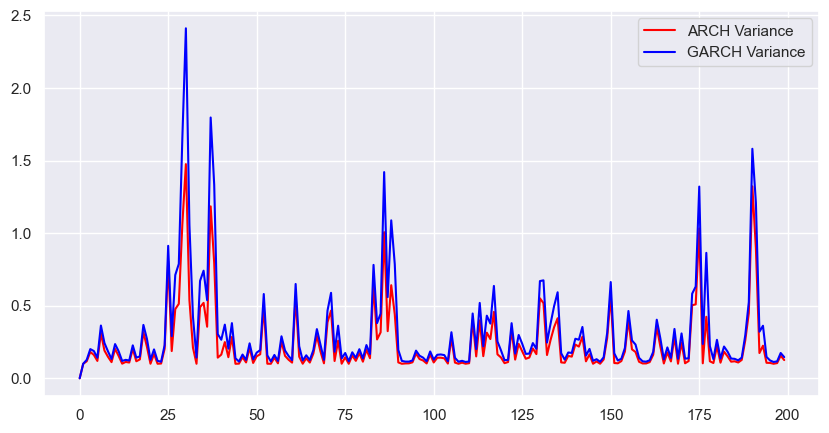

In [12]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)

# Plot the ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')

# Plot the GARCH variance
plt.plot(garch_variance, color = 'blue', label = 'GARCH Variance')
plt.legend()
plt.show()

#### Observe the impact of model parameters

Nous allons à nouveau appeler la fonction `simulate_GARCH()` et étudier l'impact des paramètres du modèle GARCH sur les résultats simulés.

Plus précisément, nous allons simuler deux séries temporelles `GARCH(1,1)`. Elles auront le même $\omega$ et $\alpha$, mais des valeurs de $\beta$ différentes en entrée.

Rappelez-vous que dans `GARCH(1,1)`, puisque $\beta$ est le coefficient de la variance de retard 1, si $\alpha$ est fixé, plus $\beta$ est grand, plus la durée de l'impact est longue. En d'autres termes, les périodes de volatilité élevée ou faible ont tendance à persister. Soyez attentif aux résultats tracés et voyez si nous pouvons vérifier l'impact de $\beta$.


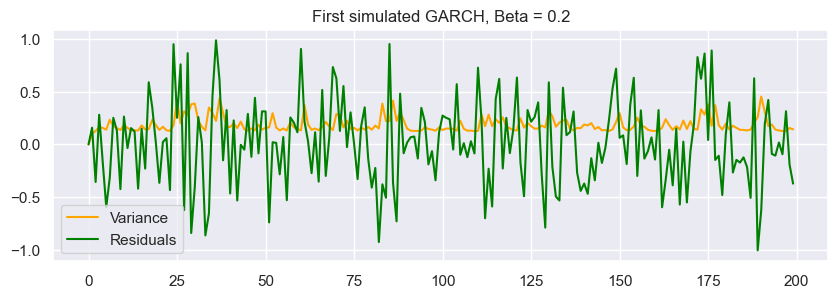

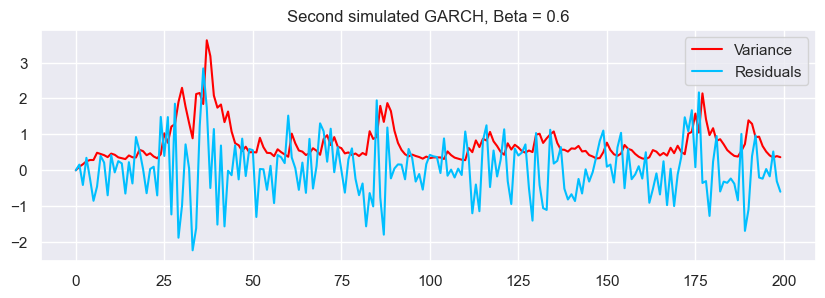

In [13]:
# First simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Second simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.title('Second simulated GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

### Implement a basic GARCH model
Nous allons nous familiariser avec le package Python `arch` et utiliser ses fonctions telles que `arch_model` pour mettre en œuvre un modèle `GARCH(1,1)`.

Tout d'abord, définissons un modèle `GARCH(1,1)` de base, puis ajustons le modèle, examinons le résumé de l'ajustement du modèle et traçons les résultats.

In [14]:
# Specify GARCH model assumptions
basic_gm = arch_model(sp_data['Log_Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 3, disp='off')

In [15]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8052.47
Distribution:                  Normal   AIC:                           16112.9
Method:            Maximum Likelihood   BIC:                           16139.6
                                        No. Observations:                 5786
Date:                Fri, Mar 01 2024   Df Residuals:                     5785
Time:                        11:07:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0587  1.079e-02      5.442  5.273e-08 [3.

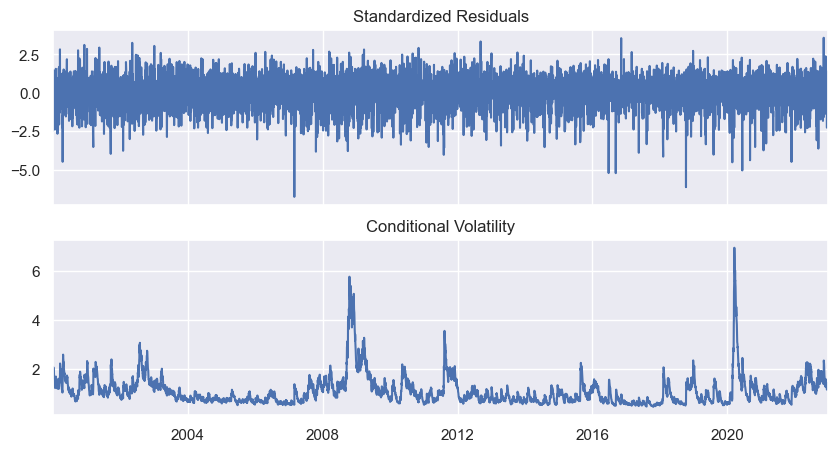

In [16]:
# Plot fitted results
gm_result.plot()
plt.show()

### Make forecast with GARCH models
We will practice making a basic volatility forecast.

We will call `.forecast()` to make a prediction. By default it produces a 1-step ahead estimate.  
You can use horizon = n to specify longer forward periods.

In [73]:
# Diviser les données en données d'entraînement et de test
train_data = sp_data[:'2010-01-01']
test_data = sp_data['2010-01-01':]
test_data

,Open,High,Low,Close,Adj Close,Volume,Return,Log_Return
Date,,,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,1.604342,1.591608
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.311568,0.311083
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.054552,0.054537
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.400120,0.399322
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.288173,0.287758
...,...,...,...,...,...,...,...,...
2022-12-23,3815.110107,3845.800049,3797.010010,3844.820068,3844.820068,2819280000,0.586810,0.585095
2022-12-27,3843.340088,3846.649902,3813.219971,3829.250000,3829.250000,3030300000,-0.404962,-0.405784
2022-12-28,3829.560059,3848.320068,3780.780029,3783.219971,3783.219971,3083520000,-1.202064,-1.209347


In [74]:
#train_data = pd.Series(train_data.values.squeeze(), index=train_data.index)

# Ajuster le modèle GARCH aux données d'entraînement
model = arch_model(train_data['Log_Return'], vol='Garch', p = 1, q = 1,
                      mean = 'constant', dist = 'normal')
model_fit = model.fit(update_freq = 3, disp='off')

# Prédire la volatilité sur les données de test
forecast_volatility = model_fit.forecast(horizon=len(test_data))
forecast_volatility = pd.DataFrame(forecast_volatility.variance.values[-1, :], index=test_data.index)
forecast_volatility.rename(columns={0: 'volatility'}, inplace=True)

# Print the forecast variance
forecast_volatility.head()

,volatility
Date,
2010-01-04,0.596615
2010-01-05,0.603337
2010-01-06,0.610013
2010-01-07,0.616643
2010-01-08,0.623229


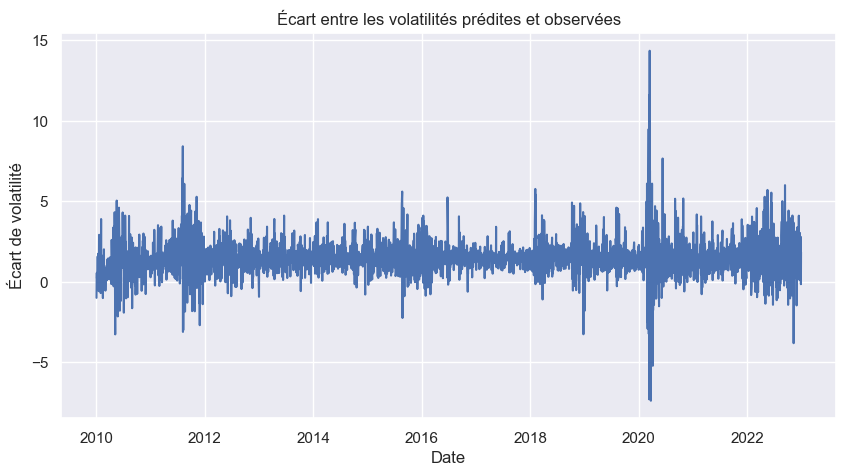

In [79]:
# Calculer l'écart entre les volatilités prédites et observées
ecart = forecast_volatility['volatility'] - test_data['Log_Return']

# Tracer l'écart
plt.plot(ecart)
plt.xlabel('Date')
plt.ylabel('Écart de volatilité')
plt.title("Écart entre les volatilités prédites et observées")
plt.show()

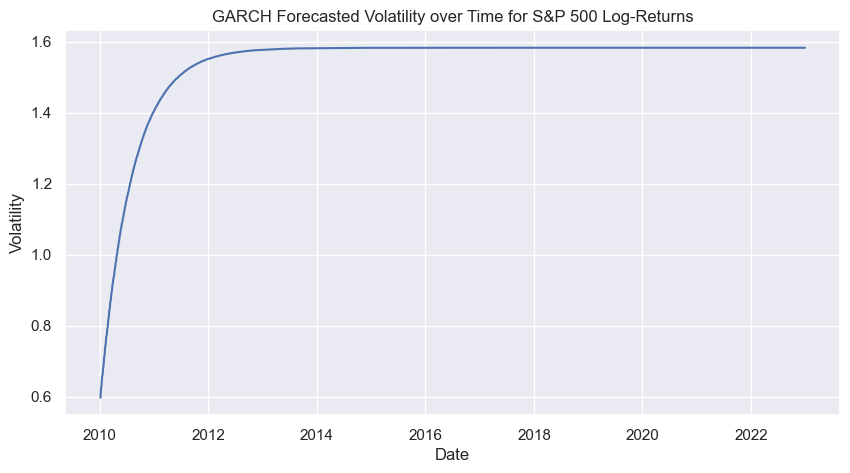

In [86]:
# Afficher la volatilité prédite
plt.plot(forecast_volatility)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('GARCH Forecasted Volatility over Time for S&P 500 Log-Returns')
plt.show()

In [64]:
# Make 5-period ahead forecast
gm_forecast = model_fit.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance)


                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2009-12-31  0.596615  0.603337  0.610013  0.616643  0.623229


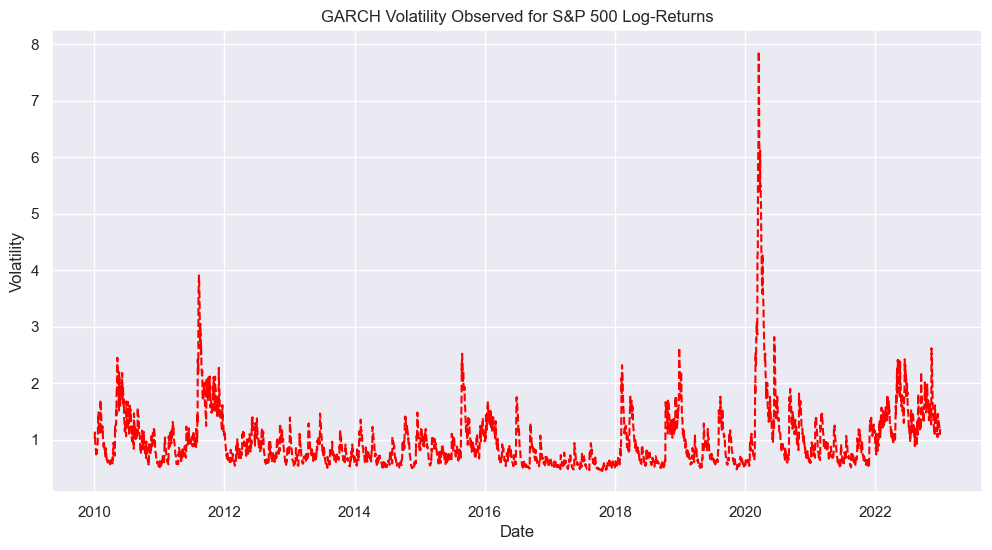

In [76]:
# Observed Volatility
Model = arch_model(test_data['Log_Return'], vol='Garch', p = 1, q = 1,
                      mean = 'constant', dist = 'normal')
Model_fit = Model.fit(update_freq = 3, disp='off')

volatility_observed = Model_fit.conditional_volatility

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.plot(volatility_observed.index, volatility_observed, linestyle='--', color='red')
plt.title('GARCH Volatility Observed for S&P 500 Log-Returns')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()